In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
import glob
from matplotlib.ticker import LogLocator, FuncFormatter

In [76]:

# 푸드 데이터 로드
path_food = r"D:\GIT\ML_MINI_4TEAM-main\ML_MINI_4TEAM-main\data\EC_SNS_KFOOD_ATTRACTION_DATA_*.csv"
files_food = glob.glob(path_food)
df_food = [pd.read_csv(f, encoding="utf-8") for f in files_food]
sns_kfood = pd.concat(df_food, ignore_index=True)

# 뷰티 데이터 로드
path_beauty = r"D:\GIT\ML_MINI_4TEAM-main\ML_MINI_4TEAM-main\data\EC_SNS_KBEAUTY_ATTRACTION_DATA_*.csv"
files_beauty = glob.glob(path_beauty)
df_beauty = [pd.read_csv(f, encoding="utf-8") for f in files_beauty]
sns_beauty = pd.concat(df_beauty, ignore_index=True)

# 데이터 병합
full_df = pd.concat([sns_kfood, sns_beauty], ignore_index=True)

In [77]:
# 채널 이름이 체널 전체인 것들만 추출 후 0으로 초기화
full_df = full_df[full_df['CHNNEL_NM'] == '채널전체'].copy()
full_df = full_df.fillna(0)

# 사용할 컬럼 추출
use_cols = ['BASE_YM', 'CTPRVN_NM', 'SIGNGU_NM', 'TURSM_CSTMR_CO', 
            'TURSM_SPND_PRICE', 'NATIVE_TURSM_SPND_PRICE', 
            'FRNR_TURSM_SPND_PRICE', 'AVRG_SCORE_VALUE', 'REVIEW_CO', 
            'BASE_YM_FQ_CO', 'BASE_YEAR_BEFORE_MT_FQ_CO'] 
df_sub = full_df[use_cols].copy()

# 데이터 형 변환
df_sub['BASE_YM'] = pd.to_datetime(df_sub['BASE_YM'], format='%Y%m')
df_sub = df_sub.fillna(0)

# 통합 데이터 셋 (뷰티는 구별로 다른 구간도 있고 같은 구간도 있어서 평균으로 처리함)    
final_df = df_sub.groupby(['BASE_YM', 'CTPRVN_NM', 'SIGNGU_NM']).agg({
    'TURSM_SPND_PRICE': 'mean',          # 관광소비금액
    'TURSM_CSTMR_CO': 'mean',            # 관광고객수
    'NATIVE_TURSM_SPND_PRICE': 'mean',   # 내국인관광소비금액
    'FRNR_TURSM_SPND_PRICE': 'mean',     # 외국인관광소비금액
    'AVRG_SCORE_VALUE': 'mean',          # 평점값
    'REVIEW_CO': 'mean',                 # 리뷰수
    'BASE_YM_FQ_CO': 'sum',              # 기준년월빈도수
    'BASE_YEAR_BEFORE_MT_FQ_CO' : 'sum'  # SNS기준년도이전우러빈도수
}).reset_index()

# SNS 한 달 간의 증감량
final_df['SNS_MONTHLY_DIFF'] = final_df['BASE_YM_FQ_CO'] - final_df['BASE_YEAR_BEFORE_MT_FQ_CO']


In [78]:

# pct_change(): 전년대비 변화량을 계산해 주는 함수 <(현재값 - 이전값) / 이전값>
# diff() : 이전값 대비 현재값의 변화량을 계산해 주는 함수 <현재값 - 이전값>
# (현재값 - 이전값) / 이전값 * 100 = 현재 성장률
final_df = final_df.sort_values(['SIGNGU_NM', 'BASE_YM'])   # pct_change()를 쓰려면 정렬이 필요
final_df = final_df.reset_index(drop=True)

# 몇몇개의 시군구명이 KR로 들어가 있는 데이터랑 '0' 들어가 있는 데이터 제거
final_df = final_df[~final_df['SIGNGU_NM'].isin(['KR', '0', 0])]
final_df = final_df.reset_index(drop=True)

# 전월 대비 소비 증감률 = (현재달 - 지난달) / 지난달 * 100
# final_df['SPND_GROWTH_RATE'] = final_df.groupby('SIGNGU_NM')['TURSM_SPND_PRICE'].pct_change() * 100
# 전월 대비 소비 증감액 = 현재달 - 지난달 (단위: 백만원)
final_df['SPND_DIFF_VALUE'] = final_df.groupby('SIGNGU_NM')['TURSM_SPND_PRICE'].diff() / 1000000

# 관광고객수 증감률 / 증감액
# final_df['CSTMR_GROWTH_RATE'] = final_df.groupby('SIGNGU_NM')['TURSM_CSTMR_CO'].pct_change() * 100
final_df['CSTMR_DIFF_VALUE'] = final_df.groupby('SIGNGU_NM')['TURSM_CSTMR_CO'].diff()

# 리뷰수 증감률 / 증감수
# final_df['REVIEW_GROWTH_RATE'] = final_df.groupby('SIGNGU_NM')['REVIEW_CO'].pct_change() * 100
final_df['REVIEW_DIFF_VALUE'] = final_df.groupby('SIGNGU_NM')['REVIEW_CO'].diff()

# 검색빈도수 증감수
final_df['SNS_DIFF_VALUE'] = final_df.groupby('SIGNGU_NM')['BASE_YEAR_BEFORE_MT_FQ_CO'].diff()   

# 결측치 및 무한대를 이전 값으로 처리 
# 변화률 위주이기 때문에 0을 넣어서 이전달과 변화가 없다 라고 평가하는게 맞다고 봄
final_df = final_df.replace([np.inf, -np.inf], np.nan)
final_df = final_df.fillna(0)

# 이상치 제거
# 중간에 보면 증감률이 8000 까지 뛸때가 있음
# 실측 오류이거나 데이터 등록에서 오류가 발생했다고 보고 마찬가지로 변화가 없다는 의미의 0으로 처리
# final_df.loc[abs(final_df['SPND_GROWTH_RATE']) > 500, ['SPND_GROWTH_RATE', 'SPND_DIFF_VAL_M']] = 0
# final_df.loc[abs(final_df['CSTMR_GROWTH_RATE']) > 500, ['CSTMR_GROWTH_RATE', 'CSTMR_DIFF_VALUE']] = 0
# final_df.loc[abs(final_df['REVIEW_GROWTH_RATE']) > 500, ['REVIEW_GROWTH_RATE', 'REVIEW_DIFF_VALUE']] = 0

# 증감률 즉 퍼센테이지는 당장에 필요 없을꺼같아서 우선 주석처리 해봤습니다.

final_df

,BASE_YM,CTPRVN_NM,SIGNGU_NM,TURSM_SPND_PRICE,TURSM_CSTMR_CO,NATIVE_TURSM_SPND_PRICE,FRNR_TURSM_SPND_PRICE,AVRG_SCORE_VALUE,REVIEW_CO,BASE_YM_FQ_CO,BASE_YEAR_BEFORE_MT_FQ_CO,SNS_MONTHLY_DIFF,SPND_DIFF_VALUE,CSTMR_DIFF_VALUE,REVIEW_DIFF_VALUE,SNS_DIFF_VALUE
0,2025-02-01,경기도,가평군,4526283.0,1330686.0,4356036.0,170247.0,4.4,36432.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,2025-07-01,경기도,가평군,655573.0,2688308.0,285133.0,370440.0,4.4,36800.000000,1.0,0.0,1.0,-3.870710,1357622.0,368.000000,0.0
2,2025-08-01,경기도,가평군,56729443.0,3322011.0,56258056.0,471387.0,4.4,36877.000000,1.0,1.0,0.0,56.073870,633703.0,77.000000,1.0
3,2025-09-01,경기도,가평군,39090303.0,2051913.0,38434403.0,655900.0,4.4,30306.666667,2.0,1.0,1.0,-17.639140,-1270098.0,-6570.333333,0.0
4,2025-10-01,경기도,가평군,48143693.0,2644120.0,47364911.0,778782.0,4.4,30416.666667,0.0,2.0,-2.0,9.053390,592207.0,110.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,2025-11-01,강원특별자치도,홍천군,33648648.0,1640793.0,33445264.0,203384.0,4.3,6697.000000,0.0,0.0,0.0,-9.659481,-606483.0,2.000000,0.0
852,2025-12-01,강원특별자치도,홍천군,36272116.0,1632712.0,34719603.0,1552513.0,4.3,6705.000000,0.0,0.0,0.0,2.623468,-8081.0,8.000000,0.0
853,2025-03-01,서울특별시,화양동,37341094.0,6797980.0,22373501.0,14967593.0,4.1,812.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
854,2025-04-01,서울특별시,화양동,33977729.0,5887682.0,21736852.0,12240877.0,4.1,817.000000,0.0,0.0,0.0,-3.363365,-910298.0,5.000000,0.0


In [79]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = r"C:\Windows\Fonts\malgun.ttf"

font_name = fm.FontProperties(fname=font_path).get_name()

plt.rcParams["font.family"] = font_name
plt.rcParams["axes.unicode_minus"] = False 

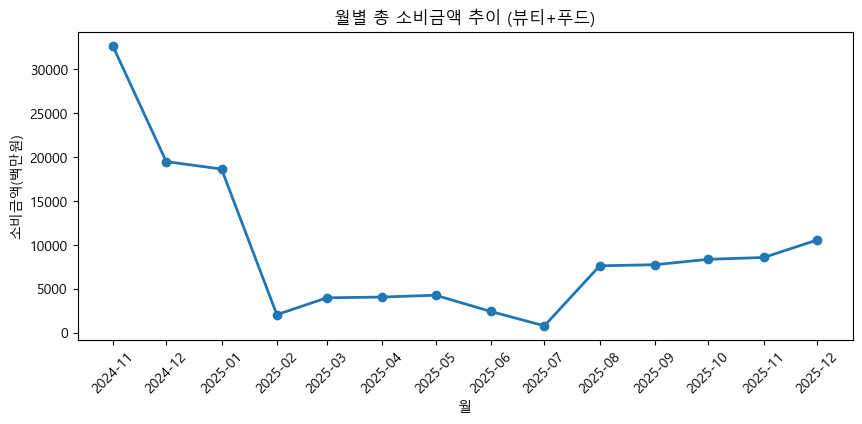

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

monthly = final_df.copy()
monthly["BASE_YM"] = pd.to_datetime(monthly["BASE_YM"])

total_month = (monthly.groupby("BASE_YM")["TURSM_SPND_PRICE"]
               .sum()
               .reset_index()
               .sort_values("BASE_YM"))


total_month["TURSM_SPND_PRICE"] = total_month["TURSM_SPND_PRICE"] / 1_000_000

plt.figure(figsize=(10, 4))
plt.plot(total_month["BASE_YM"], total_month["TURSM_SPND_PRICE"], marker="o", linewidth=2)

plt.title("월별 총 소비금액 추이 (뷰티+푸드)")
plt.xlabel("월")
plt.ylabel("소비금액(백만원)")
plt.xticks(total_month["BASE_YM"], total_month["BASE_YM"].dt.strftime("%Y-%m"), rotation=45)
plt.show()


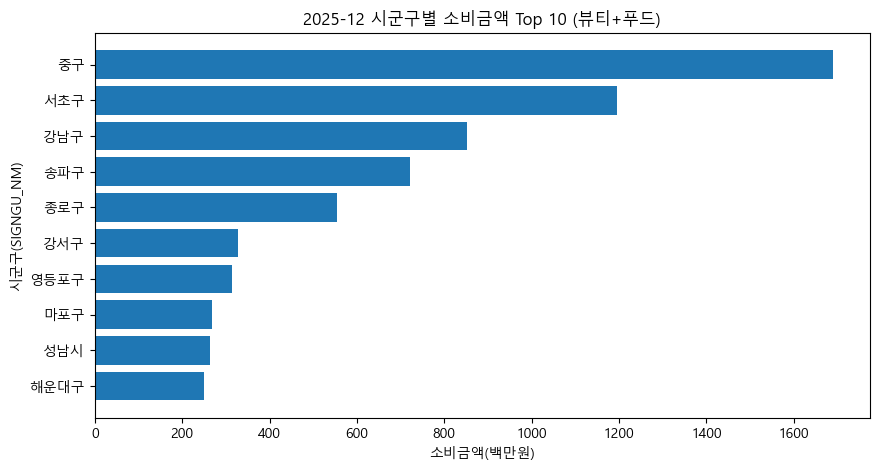

In [87]:
monthly = final_df.copy()
monthly["BASE_YM"] = pd.to_datetime(monthly["BASE_YM"])

latest_month = monthly["BASE_YM"].max()

latest_top = (monthly[monthly["BASE_YM"] == latest_month]
              .groupby("SIGNGU_NM")["TURSM_SPND_PRICE"]
              .sum()
              .sort_values(ascending=False)
              .head(10))

plt.figure(figsize=(10,5))
plt.barh(latest_top.index[::-1], (latest_top.values[::-1] / 1_000_000))  # ✅ 값도 백만원
plt.title(f"{latest_month.strftime('%Y-%m')} 시군구별 소비금액 Top 10 (뷰티+푸드)")
plt.xlabel("소비금액(백만원)")
plt.ylabel("시군구(SIGNGU_NM)")
plt.ticklabel_format(axis="x", style="plain", useOffset=False)
plt.show()


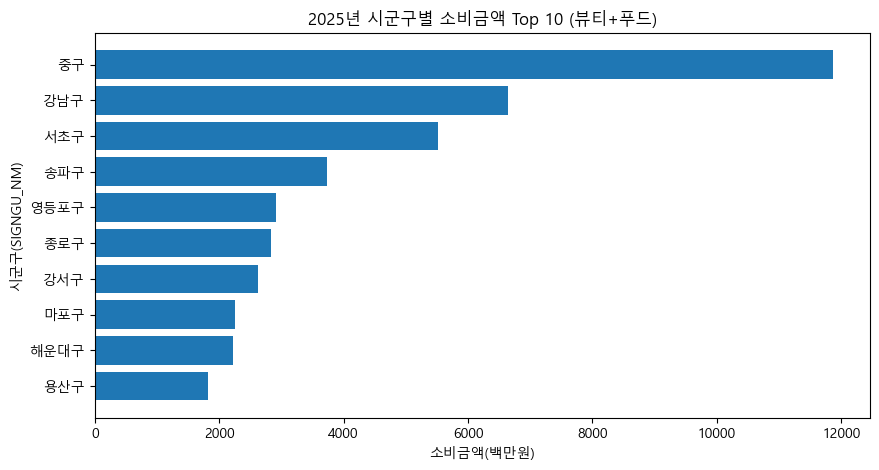

In [86]:
monthly = final_df.copy()
monthly["BASE_YM"] = pd.to_datetime(monthly["BASE_YM"])

year = 2025

latest_top = (monthly[monthly["BASE_YM"].dt.year == year]
              .groupby("SIGNGU_NM")["TURSM_SPND_PRICE"]
              .sum()
              .sort_values(ascending=False)
              .head(10))

plt.figure(figsize=(10,5))
plt.barh(latest_top.index[::-1], (latest_top.values[::-1] / 1_000_000))  # ✅ 값도 백만원
plt.title(f"{year}년 시군구별 소비금액 Top 10 (뷰티+푸드)")
plt.xlabel("소비금액(백만원)")
plt.ylabel("시군구(SIGNGU_NM)")
plt.ticklabel_format(axis="x", style="plain", useOffset=False)
plt.show()


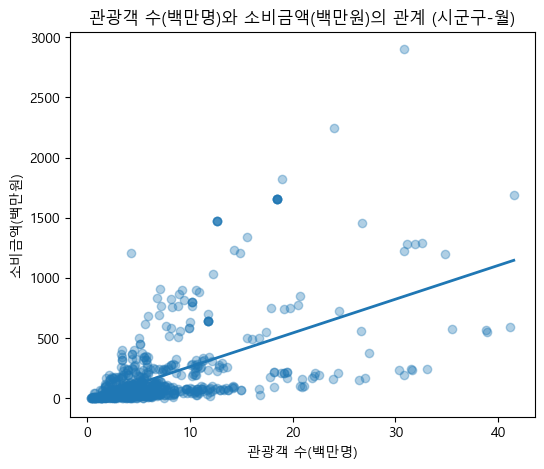

In [83]:
temp = monthly[["BASE_YM","SIGNGU_NM","TURSM_CSTMR_CO","TURSM_SPND_PRICE"]].copy()
temp["BASE_YM"] = pd.to_datetime(temp["BASE_YM"], errors="coerce")

temp["TURSM_CSTMR_CO"] = pd.to_numeric(temp["TURSM_CSTMR_CO"], errors="coerce").fillna(0)
temp["TURSM_SPND_PRICE"] = pd.to_numeric(temp["TURSM_SPND_PRICE"], errors="coerce").fillna(0)

g = (temp.dropna(subset=["BASE_YM"])
        .groupby(["BASE_YM","SIGNGU_NM"])
        .agg({"TURSM_CSTMR_CO":"sum","TURSM_SPND_PRICE":"sum"})
        .reset_index())

x = (g["TURSM_CSTMR_CO"] / 1_000_000).to_numpy() 
y = (g["TURSM_SPND_PRICE"] / 1_000_000).to_numpy() 

plt.figure(figsize=(6,5))
plt.scatter(x, y, alpha=0.35)

m = (x > 0) & (y != 0)
if m.sum() >= 2:
    a, b = np.polyfit(x[m], y[m], 1)
    xx = np.linspace(x[m].min(), x[m].max(), 200)
    plt.plot(xx, a*xx + b, linewidth=2)

plt.title("관광객 수(백만명)와 소비금액(백만원)의 관계 (시군구-월)")
plt.xlabel("관광객 수(백만명)")
plt.ylabel("소비금액(백만원)")
plt.ticklabel_format(axis="x", style="plain", useOffset=False)
plt.ticklabel_format(axis="y", style="plain", useOffset=False)
plt.show()


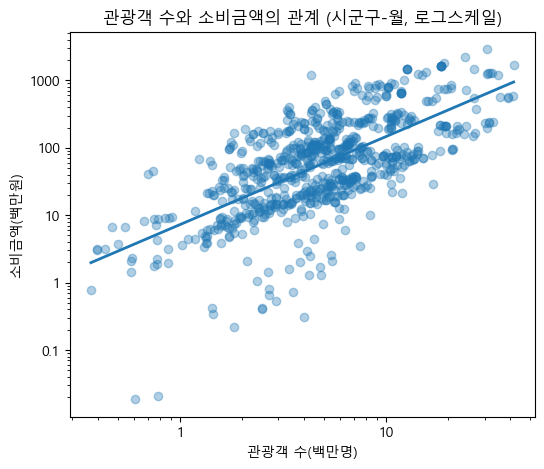

In [84]:
x = g["TURSM_CSTMR_CO"].to_numpy() / 1_000_000      # 백만명
y = g["TURSM_SPND_PRICE"].to_numpy() / 1_000_000    # 백만원

# ✅ 로그 가능한 값만
m = (x > 0) & (y > 0)
x = x[m]
y = y[m]

plt.figure(figsize=(6,5))
plt.scatter(x, y, alpha=0.35)

plt.xscale("log")
plt.yscale("log")

# ✅ 축 표기를 10^n 말고 "그냥 숫자"로 (1, 10, 100, 1000 ...)
plt.gca().xaxis.set_major_locator(LogLocator(base=10))
plt.gca().yaxis.set_major_locator(LogLocator(base=10))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{v:g}"))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{v:g}"))

# ✅ 추세선(로그축용)
if x.size >= 2:
    lx = np.log10(x)
    ly = np.log10(y)
    a, b = np.polyfit(lx, ly, 1)
    xx = np.linspace(lx.min(), lx.max(), 200)
    plt.plot(10**xx, 10**(a*xx + b), linewidth=2)

plt.title("관광객 수와 소비금액의 관계 (시군구-월, 로그스케일)")
plt.xlabel("관광객 수(백만명)")
plt.ylabel("소비금액(백만원)")
plt.show()

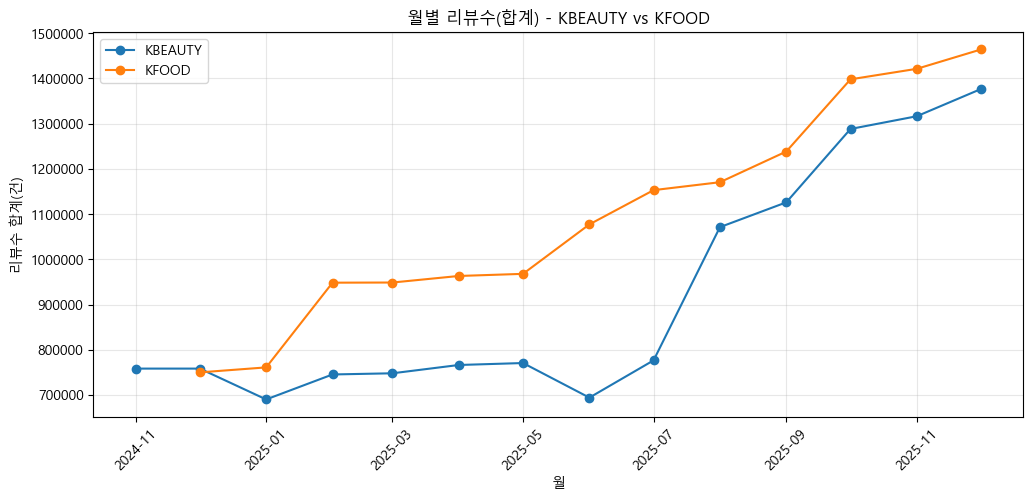

In [85]:
df_food = sns_kfood.copy()
df_food["CATEGORY"] = "KFOOD"

df_beauty = sns_beauty.copy()
df_beauty["CATEGORY"] = "KBEAUTY"

df = pd.concat([df_food, df_beauty], ignore_index=True)
df = df[df["CHNNEL_NM"] == "채널전체"].copy()

# 날짜(월)
df["BASE_YM"] = df["BASE_YM"].astype(str).str.strip()
df["MONTH"] = pd.to_datetime(df["BASE_YM"], format="%Y%m", errors="coerce")

# 리뷰수 숫자형 변환
df["REVIEW_CO"] = pd.to_numeric(df["REVIEW_CO"], errors="coerce").fillna(0)

# 뷰티/푸드
df2 = df[df["CATEGORY"].isin(["KBEAUTY", "KFOOD"])].copy()

# 월별 + 카테고리별 리뷰수 합계
monthly = (
    df2.groupby(["MONTH", "CATEGORY"])["REVIEW_CO"]
       .sum()
       .reset_index()
       .sort_values("MONTH")
)

plt.figure(figsize=(12, 5))

for category_name, group_df in monthly.groupby("CATEGORY"):
    plt.plot(group_df["MONTH"], group_df["REVIEW_CO"], marker="o", label=category_name)

plt.title("월별 리뷰수(합계) - KBEAUTY vs KFOOD")
plt.xlabel("월")
plt.ylabel("리뷰수 합계(건)")
plt.ticklabel_format(axis="y", style="plain", useOffset=False)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


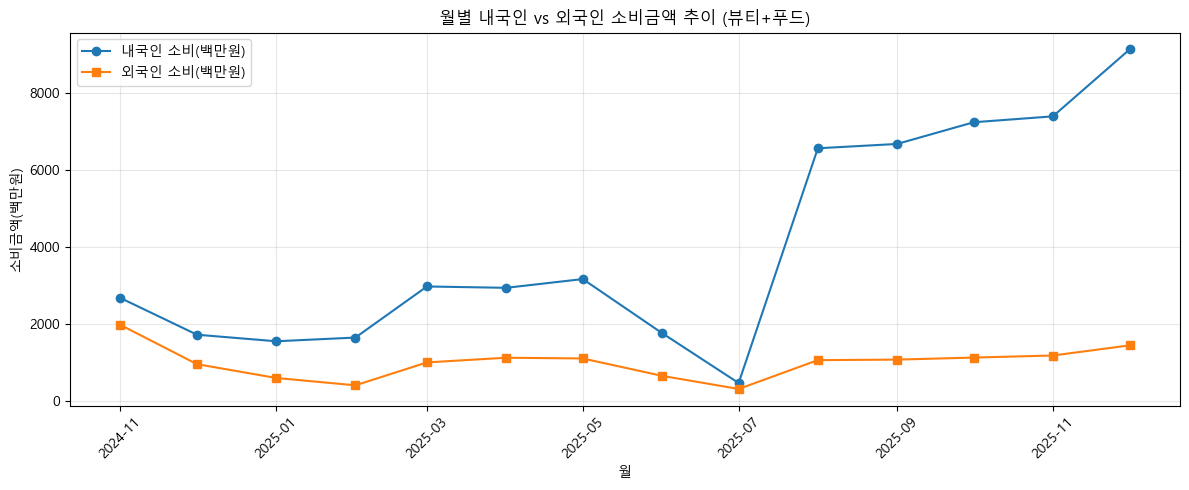

In [89]:
monthly_nf = (final_df.groupby("BASE_YM")[["NATIVE_TURSM_SPND_PRICE", "FRNR_TURSM_SPND_PRICE"]]
              .sum()
              .reset_index()
              .sort_values("BASE_YM"))

plt.figure(figsize=(12,5))
plt.plot(monthly_nf["BASE_YM"], monthly_nf["NATIVE_TURSM_SPND_PRICE"]/1_000_000, marker="o", label="내국인 소비(백만원)")
plt.plot(monthly_nf["BASE_YM"], monthly_nf["FRNR_TURSM_SPND_PRICE"]/1_000_000, marker="s", label="외국인 소비(백만원)")

plt.title("월별 내국인 vs 외국인 소비금액 추이 (뷰티+푸드)")
plt.xlabel("월")
plt.ylabel("소비금액(백만원)")
plt.ticklabel_format(axis="y", style="plain", useOffset=False)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


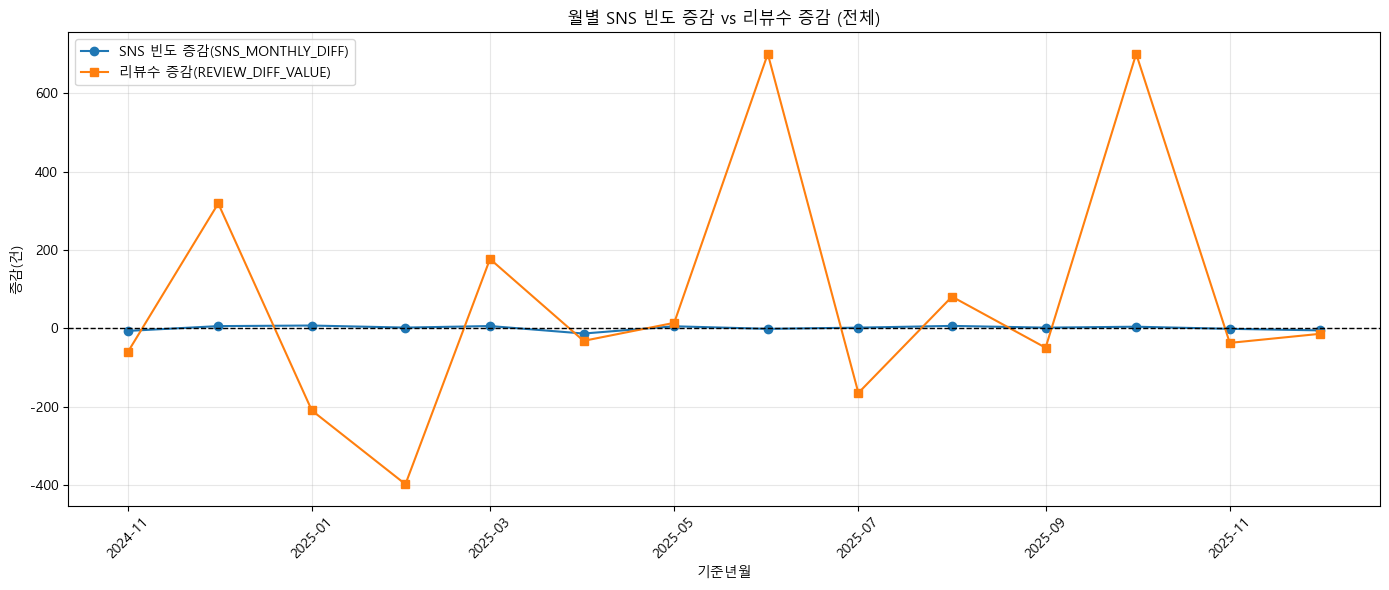

In [ ]:
# SNS에서 언급이 늘어난 달에 실제 리뷰가 늘어 났는지

monthly_diff = (final_df.groupby("BASE_YM")[["SNS_MONTHLY_DIFF", "REVIEW_DIFF_VALUE"]]
                .mean()
                .reset_index()
                .sort_values("BASE_YM"))

plt.figure(figsize=(14,6))
plt.plot(monthly_diff["BASE_YM"], monthly_diff["SNS_MONTHLY_DIFF"], marker="o", label="SNS 빈도 증감(SNS_MONTHLY_DIFF)")
plt.plot(monthly_diff["BASE_YM"], monthly_diff["REVIEW_DIFF_VALUE"], marker="s", label="리뷰수 증감(REVIEW_DIFF_VALUE)")

plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.title("월별 SNS 빈도 증감 vs 리뷰수 증감 (전체)")
plt.xlabel("기준년월")
plt.ylabel("증감(건)")
plt.ticklabel_format(axis="y", style="plain", useOffset=False)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


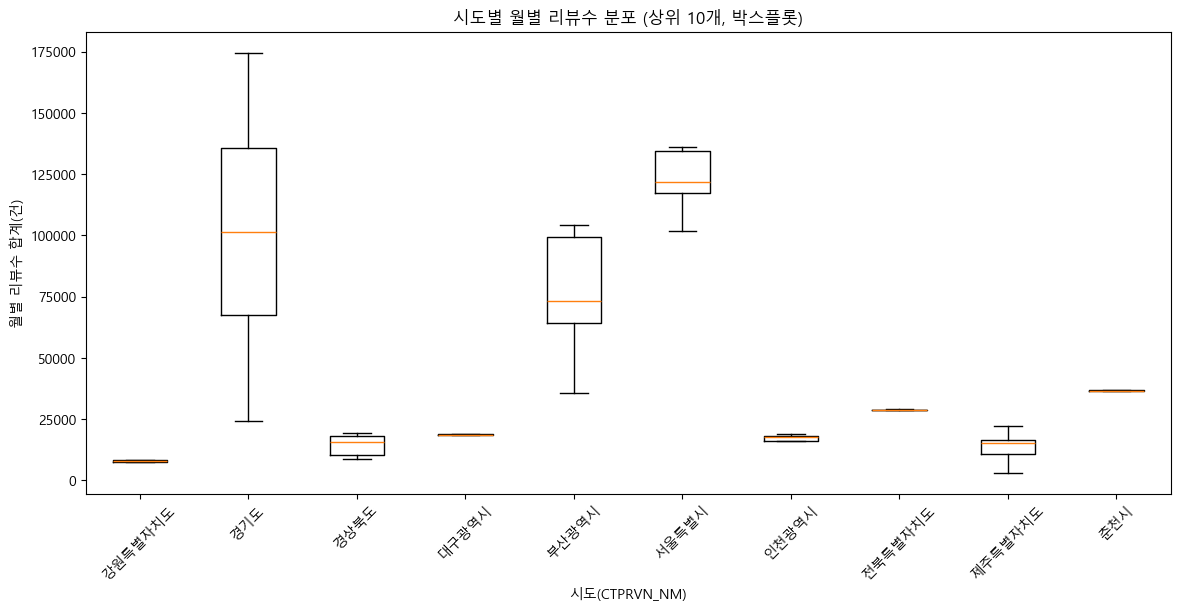

In [97]:
top10 = (rm.groupby("CTPRVN_NM")["REVIEW_CO"]
           .sum()
           .sort_values(ascending=False)
           .head(10)
           .index)

rm_top = rm[rm["CTPRVN_NM"].isin(top10)]
grp = rm_top.groupby("CTPRVN_NM")["REVIEW_CO"]

plt.figure(figsize=(14,6))
plt.boxplot([v.to_numpy() for _, v in grp], tick_labels=[k for k, _ in grp], showfliers=False)

plt.title("시도별 월별 리뷰수 분포 (상위 10개, 박스플롯)")
plt.xlabel("시도(CTPRVN_NM)")
plt.ylabel("월별 리뷰수 합계(건)")
plt.ticklabel_format(axis="y", style="plain", useOffset=False)
plt.xticks(rotation=45)
plt.show()
